In [10]:
import os
import numpy as np

import torch as th
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# from safetensors.torch import save_model, load_model

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

from typing import List, Union, Callable, Tuple
from torch import Tensor

from einops import rearrange
from torchsummary import summary

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.3,
	},
)

# # Constant hyperparameters
DEVICE_AUTODETECT: bool = True
TRAIN_BATCH_SIZE: int = 64	# Batch size for training
TEST_BS: int = 1024	# Batch size for testing
EPOCHS: int = 50	# Number of epochs

CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="mean")
)
EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="sum")
)
LR: float = 1e-4	# Learning rate

In [11]:
# Device setup
device: th.device = th.device(
    "mps" if th.backends.mps.is_available() and DEVICE_AUTODETECT else "cpu"
)

In [12]:
# Define the transformations for the training datasets (data augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    #transforms.RandomAffine(0, shear=10),  # Randomly apply affine transformations (shear and scale)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation and hue
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the transformations for the testing datasets
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/cleaned/Training'
test_dir = 'datasets/cleaned/Testing'

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Create the DataLoaders
train_loader: DataLoader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False)

# Use only a small subset of the data for training to test the model
#test_train_dataset = th.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), 500))
#train_loader = DataLoader(test_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


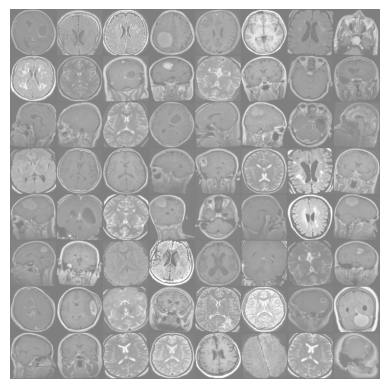

0 2 2 1 2 2 2 3 2 2 0 1 2 3 3 0 3 0 2 0 3 1 0 2 2 2 2 0 1 2 2 3 1 0 2 1 0 3 2 1 1 1 2 2 2 0 2 1 0 1 2 3 2 2 0 1 3 3 2 2 2 2 2 0


In [13]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(tv.utils.make_grid(images))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(len(labels))))

In [14]:
class VisionTransformer(th.nn.Module):
    def __init__(self, img_size=128, patch_size=16, num_classes=4, dim=512, depth=10, heads=8, mlp_dim=1024, dropout=0.2):
        super().__init__()

        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (img_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size  # 3 channels for RGB

        # Patch embedding
        self.patch_embed = th.nn.Linear(patch_dim, dim)

        # Positional encoding
        self.pos_embedding = th.nn.Parameter(th.randn(1, num_patches + 1, dim))
        self.cls_token = th.nn.Parameter(th.randn(1, 1, dim))
        self.dropout = th.nn.Dropout(dropout)

        # Transformer encoder layers
        self.transformer_layers = th.nn.ModuleList([
            th.nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout, batch_first=True)
            for _ in range(depth)
        ])
        self.norm = th.nn.LayerNorm(dim)

        # Classification head
        self.to_cls_token = th.nn.Identity()
        self.mlp_head = th.nn.Sequential(
            th.nn.LayerNorm(dim),
            th.nn.Linear(dim, num_classes),
            th.nn.Dropout(dropout) # Dropout before the classifier
        )

    def forward(self, x):
        # x: [batch_size, channels, height, width]
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)  # Flatten patches
        x = self.patch_embed(x)  # [batch_size, num_patches, dim]

        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = th.cat((cls_tokens, x), dim=1)  # Add class token
        x += self.pos_embedding  # Add positional encoding
        x = self.dropout(x)

        # Transformer encoder
        for layer in self.transformer_layers:
            x = layer(x) + x  # Residual connection
            x = self.norm(x)

        # Classify
        cls_token_final = self.to_cls_token(x[:, 0])  # Use class token
        return self.mlp_head(cls_token_final)

In [15]:
# Create the model
model: VisionTransformer = VisionTransformer().to(device)
model.train()

VisionTransformer(
  (patch_embed): Linear(in_features=768, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer_layers): ModuleList(
    (0-9): 10 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (linear2): Linear(in_features=1024, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (to_cls_token): Identity()
  (mlp_head): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512

In [16]:
# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 21459460


In [17]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=1e-5 # L2 regularization
)

# Let's define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [18]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()
        
    # Step the scheduler
    scheduler.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)

Training epoch: 100%|██████████| 50/50 [55:15<00:00, 66.30s/it]


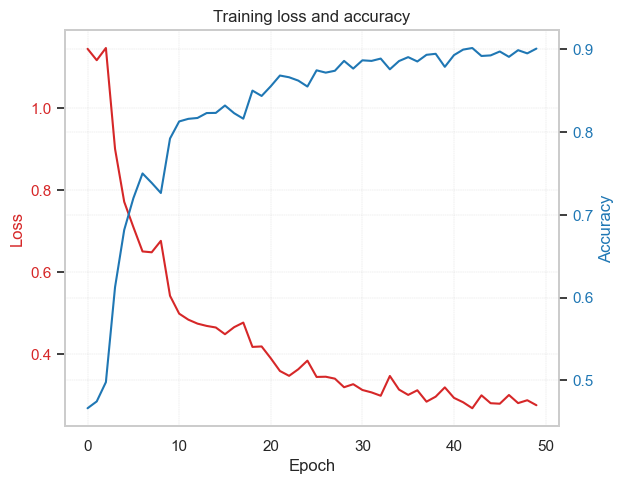

In [19]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [20]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 0.27429849067989853
Final training accuracy: 0.9009103641456583


In [21]:
# Evaluate the model on the test set
model.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = model(x_e)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc.append(trackingcorrect / num_elem)
    
print(f"Final test accuracy: {test_acc[-1]}")

Final test accuracy: 0.8779557589626239
